In [ ]:
!pip install scikit-learn-extra
!pip install kneed
!pip install dtaidistance
!pip install pyclustering
!pip install --upgrade numpy

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 797 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.6-cp37-cp37m-linux_x86_64.whl size=1593652 sha256=7dec494ccc52a46ac9732291566d9e745f097250405dac69112414b47f937abe
  Stored in directory: /root/.cache/pip/wheels/a4/04/e5/ff7fd821276e7ec68893652d36b6a13f230ecdcafdc3283b3f
Successfully built dtaidistance
     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=bde6b5fbed7576215178b831bb5b78c464c111d680bb953b2d29a1e6e1809fc2
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


In [ ]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.advanced_activations import PReLU, LeakyReLU

from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA,TruncatedSVD,KernelPCA
from sklearn.manifold import TSNE,MDS,Isomap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from sklearn.metrics import davies_bouldin_score 
from sklearn_extra.cluster import KMedoids
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import LocallyLinearEmbedding
from dtaidistance import dtw, clustering
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from numpy import unique
from numpy import where
from kneed import KneeLocator
from os import listdir
from os.path import isfile, join
from random import randrange
from tqdm import tqdm

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import datetime
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab Notebooks/clustering customer encoding'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['completeddisposition.csv',
 'completedtrans.csv',
 'completedclient_edited.csv',
 'distance_matrix3.npy']

In [ ]:
df_clients_origin = pd.read_csv(dataset_path + '/completedclient_edited.csv', index_col=[0], low_memory=False)
df_transactions_origin = pd.read_csv(dataset_path + '/completedtrans.csv', index_col=[0], low_memory=False)
df_positions_origin = pd.read_csv(dataset_path + '/completeddisposition.csv', index_col=[0], low_memory=False)

In [ ]:
# Convert city to latitude and longitude

from geopy import geocoders
cities_list = list(df_clients_origin['city'].unique())
cities_dict = {}
for c in tqdm(cities_list):
  gn = geocoders.GeoNames(username='barkhordar',timeout=10)
  location = gn.geocode(c)
  cities_dict[c] = [location.latitude , location.longitude]

100%|██████████| 75/75 [00:18<00:00,  4.13it/s]


In [ ]:
df_clients = df_clients_origin.join(df_positions_origin.set_index('client_id'), on='client_id')
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,...,address_1,address_2,city,state,zipcode,district_id,latitude,longitude,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,...,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,35.08449,-106.65114,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,...,75 W. Berkshire St.,NaN,New York City,NY,10040,1,40.71427,-74.00597,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,...,36 Second St.,NaN,New York City,NY,10162,1,40.71427,-74.00597,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,...,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,39.76838,-86.15804,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,...,755 Galvin Street,NaN,Indianapolis,IN,40852,5,39.76838,-86.15804,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,...,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,40.71427,-74.00597,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,...,7021 Chapel Ave.,NaN,New York City,NY,10118,1,40.71427,-74.00597,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,...,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,41.70149,-71.15505,A00011359,Owner


In [ ]:
df_clients[['account_id','sex','age','city']]

,account_id,sex,age,city
client_id,,,,
C00000001,A00000001,Female,29,Albuquerque
C00000002,A00000002,Male,54,New York City
C00000003,A00000002,Female,59,New York City
C00000004,A00000003,Male,43,Indianapolis
C00000005,A00000003,Female,39,Indianapolis
...,...,...,...,...
C00013955,A00011349,Female,54,New York City
C00013956,A00011349,Male,56,New York City
C00013968,A00011359,Male,31,Fall River


In [ ]:
df_clients_onehot = pd.DataFrame()
df_clients_onehot['account_id']=df_clients['account_id']
sex_dict = {'Male':1.0,'Female':0.0}
df_clients_onehot['sex'] = df_clients['sex'].apply(lambda x: sex_dict.get(x))
df_clients_onehot["age"] = df_clients['age']
df_clients_onehot["latitude"] = df_clients["latitude"]
df_clients_onehot["longitude"] = df_clients["longitude"]
df_clients_onehot

,account_id,sex,age,latitude,longitude
client_id,,,,,
C00000001,A00000001,0.0,29,35.08449,-106.65114
C00000002,A00000002,1.0,54,40.71427,-74.00597
C00000003,A00000002,0.0,59,40.71427,-74.00597
C00000004,A00000003,1.0,43,39.76838,-86.15804
C00000005,A00000003,0.0,39,39.76838,-86.15804
...,...,...,...,...,...
C00013955,A00011349,0.0,54,40.71427,-74.00597
C00013956,A00011349,1.0,56,40.71427,-74.00597
C00013968,A00011359,1.0,31,41.70149,-71.15505


In [ ]:
df = df_clients_onehot
df = df [['sex','latitude','longitude','age']]
df_clients_normalized=(df-df.mean())/df.std()
df_clients_normalized['account_id']=df_clients_onehot['account_id']
df_clients_normalized

,sex,latitude,longitude,age,account_id
client_id,,,,,
C00000001,-1.014729,-0.163898,-0.646533,-0.977190,A00000001
C00000002,0.985301,0.249069,0.091451,0.468980,A00000002
C00000003,-1.014729,0.249069,0.091451,0.758214,A00000002
C00000004,0.985301,0.179684,-0.183262,-0.167334,A00000003
C00000005,-1.014729,0.179684,-0.183262,-0.398722,A00000003
...,...,...,...,...,...
C00013955,-1.014729,0.249069,0.091451,0.468980,A00011349
C00013956,0.985301,0.249069,0.091451,0.584674,A00011349
C00013968,0.985301,0.321486,0.155899,-0.861496,A00011359


In [ ]:
# Convert date to python datetime
df_transactions = df_transactions_origin
df_transactions['fulldate'] = pd.to_datetime(df_transactions['fulldate'],format="%Y-%m-%d")
df_transactions['timestamp'] = df_transactions.fulldate.values.astype(np.int64) // 10 ** 9
df_transactions

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [ ]:
from datetime import timedelta
snapshot_date = df_transactions['fulldate'].max() + timedelta(days=1)
print(snapshot_date)

2019-01-01 00:00:00


In [ ]:
# Grouping by account_id
df_rfm = df_transactions.groupby(['account_id']).agg({
        'fulldate': lambda x: (snapshot_date - x.max()).days,
        'trans_id': 'count',
        'amount': 'sum'})

In [ ]:
# Rename the columns 
df_rfm.rename(columns={'fulldate': 'Recency','trans_id': 'Frequency','amount': 'Monetary'}, inplace=True)
df_rfm

,Recency,Frequency,Monetary
account_id,,,
A00000001,1,239,375174.5
A00000002,1,478,3151479.3
A00000003,1,117,295021.8
A00000004,1,186,350971.4
A00000005,1,84,166881.4
...,...,...,...
A00011333,1,368,3295795.5
A00011349,1,304,3957372.2
A00011359,1,378,2948081.4


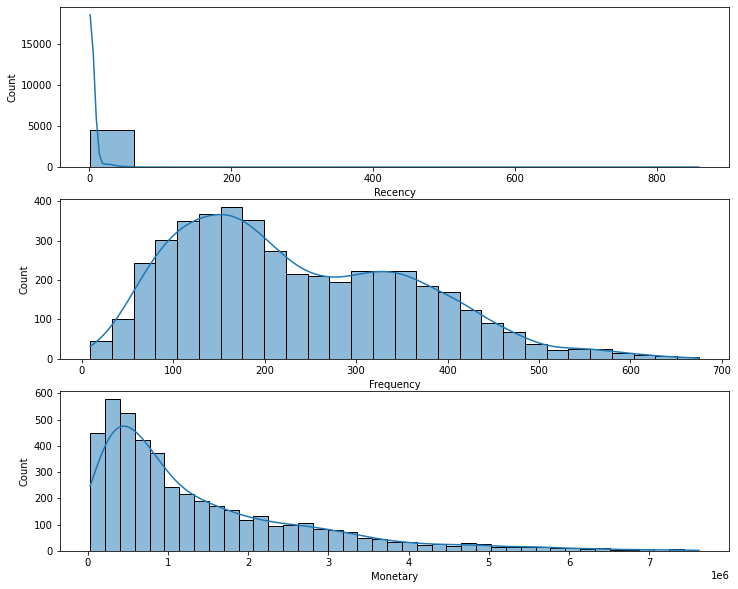

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))# Plot distribution of R
plt.subplot(3, 1, 1); sns.histplot(df_rfm['Recency'], kde=True,)# Plot distribution of F
plt.subplot(3, 1, 2); sns.histplot(df_rfm['Frequency'], kde=True)# Plot distribution of M
plt.subplot(3, 1, 3); sns.histplot(df_rfm['Monetary'], kde=True)# Show the plot
plt.show()

In [ ]:
standard_scaler = StandardScaler()
X_rfm = standard_scaler.fit_transform(df_rfm)

In [ ]:
RFM_norm1 = pd.DataFrame(X_rfm)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-0.084878,0.033604,-0.764359
1,-0.084878,1.917937,1.325454
2,-0.084878,-0.928273,-0.824692
3,-0.084878,-0.384260,-0.782577
4,-0.084878,-1.188452,-0.921147


In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H
print(hopkins(RFM_norm1))

0.9891310472819791


In [ ]:
df_transactions = df_transactions.set_index('trans_id')
df_transactions = df_transactions [['account_id','type','amount','balance','timestamp']]
df_transactions = df_transactions.sort_values('timestamp')
df_transactions

,account_id,type,amount,balance,timestamp
trans_id,,,,,
T00695247,A00002378,Credit,700.0,700.0,1356998400
T00171812,A00000576,Credit,900.0,900.0,1356998400
T00207264,A00000704,Credit,1000.0,1000.0,1356998400
T01117247,A00003818,Credit,600.0,600.0,1356998400
T00579373,A00001972,Credit,400.0,400.0,1357084800
...,...,...,...,...,...
T03629556,A00002990,Credit,175.0,42712.1,1546214400
T03630422,A00003025,Credit,73.9,15933.6,1546214400
T03631495,A00003053,Credit,349.8,86982.1,1546214400


In [ ]:
transaction_type_dict = {'Debit':1.0,'Credit':0.0}
df_transactions['type'] = df_transactions['type'].apply(lambda x: transaction_type_dict.get(x))
df_transactions

,account_id,type,amount,balance,timestamp
trans_id,,,,,
T00695247,A00002378,0.0,700.0,700.0,1356998400
T00171812,A00000576,0.0,900.0,900.0,1356998400
T00207264,A00000704,0.0,1000.0,1000.0,1356998400
T01117247,A00003818,0.0,600.0,600.0,1356998400
T00579373,A00001972,0.0,400.0,400.0,1357084800
...,...,...,...,...,...
T03629556,A00002990,0.0,175.0,42712.1,1546214400
T03630422,A00003025,0.0,73.9,15933.6,1546214400
T03631495,A00003053,0.0,349.8,86982.1,1546214400


In [ ]:
df = df_transactions
df = df [['type','amount','balance','timestamp']]
df_transactions_normalized=(df-df.mean())/df.std()
df_transactions_normalized['account_id']=df_transactions['account_id']
df_transactions_normalized

,type,amount,balance,timestamp,account_id
trans_id,,,,,
T00695247,-1.267936,-0.548597,-1.709854,-2.860870,A00002378
T00171812,-1.267936,-0.527595,-1.700812,-2.860870,A00000576
T00207264,-1.267936,-0.517094,-1.696291,-2.860870,A00000704
T01117247,-1.267936,-0.559098,-1.714375,-2.860870,A00003818
T00579373,-1.267936,-0.580101,-1.723418,-2.858917,A00001972
...,...,...,...,...,...
T03629556,-1.267936,-0.603728,0.189610,1.417798,A00002990
T03630422,-1.267936,-0.614345,-1.021108,1.417798,A00003025
T03631495,-1.267936,-0.585372,2.191159,1.417798,A00003053


In [ ]:
df_account_grouped = df_transactions_normalized.groupby(['account_id'])
df_account_grouped.size()

account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Length: 4500, dtype: int64

#DTW

In [ ]:
df_account_time_grouped = df_transactions_normalized.groupby(['account_id', 'timestamp'])['amount'].sum().reset_index(name ='Total Amount')
df_account_time_grouped

,account_id,timestamp,Total Amount
0,A00000001,-1.274442,-0.517094
1,A00000001,-1.235367,-0.235767
2,A00000001,-1.215830,0.701044
3,A00000001,-1.202154,-0.620089
4,A00000001,-1.176755,-0.235767
...,...,...,...
814763,A00011382,1.357232,-1.820773
814764,A00011382,1.361140,2.066198
814765,A00011382,1.376770,4.234482
814766,A00011382,1.406076,0.039469


In [ ]:
df_account_grouped = df_account_time_grouped.groupby(['account_id'])
df_account_grouped.get_group('A00000001')

,account_id,timestamp,Total Amount
0,A00000001,-1.274442,-0.517094
1,A00000001,-1.235367,-0.235767
2,A00000001,-1.215830,0.701044
3,A00000001,-1.202154,-0.620089
4,A00000001,-1.176755,-0.235767
...,...,...,...
182,A00000001,1.357232,-1.235631
183,A00000001,1.363094,-0.149552
184,A00000001,1.367001,-0.364616
185,A00000001,1.382631,-0.235767


In [ ]:
dtw_list = []
for a in df_clients['account_id'].unique():
  tmp = df_account_grouped.get_group(a)
  dtw_child_list = tmp.reset_index()[['Total Amount']].values.tolist()
  dtw_child_list = [item for sublist in dtw_child_list for item in sublist]
  dtw_child_list = np.array(dtw_child_list)
  dtw_list.append(dtw_child_list)
  

In [ ]:
ds = dtw.distance_matrix_fast(dtw_list)

In [ ]:
from numpy import save
save('distance_matrix3.npy', ds)

#MODEL

In [ ]:
max_length_of_transaction = df_account_grouped['amount'].count().max()
print("max trans lenght is: ", max_length_of_transaction)

max trans lenght is:  675


In [ ]:
df_account_grouped.get_group('A00000001')

,type,amount,balance,timestamp,account_id
trans_id,,,,,
T00000001,-1.267936,-0.517094,-1.696291,-1.274442,A00000001
T00000005,-1.267936,-0.235767,-1.529954,-1.235367,A00000001
T00000199,-1.267936,0.701044,-0.960279,-1.215830,A00000001
T03530438,-1.267936,-0.620089,-0.959411,-1.202154,A00000001
T00000006,-1.267936,-0.235767,-0.793075,-1.176755,A00000001
...,...,...,...,...,...
T03530481,-1.267936,-0.615059,-0.986389,1.357232,A00000001
T00000230,0.788683,-0.149552,-1.190505,1.363094,A00000001
T00000097,0.788683,-0.364616,-1.301366,1.367001,A00000001


In [ ]:
sequence_input_list = []
sequence_output_list = []
for k, v in df_account_grouped:
  user_trans_array = pd.concat([v.type,v.amount,v.balance, v.timestamp], axis=1).values
  array = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1, -1,-1, -1], axis=0)
  input_array = np.append(add_start_to_array, [[-2, -2,-2, -2]], axis=0)
  output_array = np.append(array, [[-2, -2,-2, -2]], axis=0)
  # resize array to max_lenght
  input_array.resize((max_length_of_transaction,4), refcheck=False)
  output_array.resize((max_length_of_transaction,4), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)

In [ ]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
sequence_output_array.shape

(4500, 675, 4)

In [ ]:
(sequence_output_input_array == sequence_output_array).all()

False

In [ ]:
# Build static input array
list_of_account_ids = list(df_account_grouped.groups.keys())
static_input_list = []
for account_id in list_of_account_ids:
  sub_df = df_clients_normalized.loc[df_clients_normalized['account_id'] == account_id]
  sub_df = sub_df.iloc[0]
  account_static_vector = sub_df[['sex','age','latitude','longitude']].values.tolist()
  static_input_list.append(account_static_vector)
static_input_array = np.array(static_input_list)
print(static_input_array.shape)
static_output_array = static_input_array
static_input_array

(4500, 4)


array([[-1.01472945, -0.9771898 , -0.1638979 , -0.6465329 ],
       [ 0.98530081,  0.46898042,  0.24906924,  0.0914507 ],
       [ 0.98530081, -0.16733447,  0.17968438, -0.18326156],
       ...,
       [ 0.98530081, -0.86149618,  0.32148583,  0.1558992 ],
       [-1.01472945, -0.51441533,  0.29899034,  0.10392843],
       [-1.01472945,  0.00620595,  0.33238184, -0.21699025]])

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.55.46.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.46.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  }

def elbow_method(X):
  # A list holds the SSE values for each k
  sse = []
  for k in range(1, 11):
      kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
      kmeans.fit(X)
      sse.append(kmeans.inertia_)
  plt.style.use("fivethirtyeight")
  plt.plot(range(1, 11), sse)
  plt.xticks(range(1, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()
  kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
  print("Optimum number of clusters is: ", kl.elbow)
  return int(kl.elbow)

def plot_clustering(X, labels):
  if X.shape[1] == 3:
    df = pd.DataFrame({'feature1':X[:, 0],'feature2':X[:, 1],'feature3':X[:, 2],'labels':labels})
    fig = go.Figure(data=go.Scatter3d(
        x = df['feature1'],
        y = df['feature2'],
        z = df['feature3'],
        mode='markers',
        marker=dict(
            color=df['labels'],
            colorscale='Viridis',
            line_width=1
        )
    ))
    fig.update_layout(
        xaxis_title="1st principal component",
        yaxis_title="2nd principal component",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple",
        ),
        title={
          'text': "Plot Customer Clustering",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'}
        
    )
    fig.show()
  else:
    df = pd.DataFrame({'feature1':X[:, 0],'feature2':X[:, 1],'labels':labels})
    fig = go.Figure(data=go.Scattergl(
        x = df['feature1'],
        y = df['feature2'],
        mode='markers',
        marker=dict(
            color=df['labels'],
            colorscale='Viridis',
            line_width=1
        )
    ))
    fig.update_layout(
        xaxis_title="1st principal component",
        yaxis_title="2nd principal component",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple",
        ),
        title={
          'text': "Plot Customer Clustering",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'}
        
    )
    fig.show()

def do_kmeans(X, n_clusters):
  kmeans = KMeans(n_clusters = n_clusters, **kmeans_kwargs)
  kmeans.fit(X)
  print(set(kmeans.labels_))

  silhouette_avg = silhouette_score(X, kmeans.labels_)
  
  print("Silhouette: ", silhouette_avg , " The best value is 1 and the worst value is -1.")
  print("Davies–Bouldin index: ", davies_bouldin_score(X, kmeans.labels_), " lower values indicating better clustering.")
  plot_clustering(X, kmeans.labels_)

In [ ]:
def create_model():
  latent_dim = 16
  decoder_dim = 4
  num_dynamic_features = 4
  ###########################################  encoder  ###########################################

  # Sequence input shape is N*2 which N is sequence length and 2 is price and time
  sequence_input = Input(name='sequence_input', shape=(None, num_dynamic_features))

  # Many_to_one_lstm
  outputs  = LSTM(128, return_sequences=True)(sequence_input)
  # outputs = GRU(2048, return_sequences=True)(outputs)
  # outputs = Dropout(0.2, input_shape=(2,))(outputs)
  encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

  latent_space = Concatenate()([hidden_state, cell_state])
  #Layer below output can be used for clustering purposes
  latent_space = Dense(latent_dim, activation = 'relu', name='latent_space')(latent_space)

  ###########################################  /encoder  ###########################################

  ###########################################  decoder  ###########################################

  # Temporary input with a time step delay for producing sequence output
  # This input is exacly similar to sequence_input with only this diffrence that has a time step delay
  sequence_output_input = Input(name='sequence_output_input', shape=(None, num_dynamic_features))

  # One to many GRU (because of its simplicity, we used GRU instead of LSTM)
  decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input, initial_state = latent_space)
  ###########################################  attention  ###########################################
  attention = dot([decoder_out, encoder_out], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_out], axes=[2,1])
  decoder_combined_context = Concatenate()([context, decoder_out])
  ###########################################  /attention  ###########################################

  decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_combined_context)

  ###########################################  /decoder  ###########################################

  # Model has three inputs and 2 outputs (last input is temorary)
  model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

  return model

In [ ]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MSE)
  model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, None, 4)]    0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, None, 128)    68096       ['sequence_input[0][0]']         
                                                                                                  
 lstm_9 (LSTM)                  [(None, None, 16),   9280        ['lstm_8[0][0]']                 
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                            

In [ ]:
batch_size = 512
inputs = [sequence_input_array, sequence_output_input_array]
outputs = [sequence_output_array]

training_history = model.fit(inputs, outputs,
                             epochs=30,
                             batch_size = batch_size,
                             validation_split=0.1)

Epoch 1/30
8/8 [==============================] - 23s 2s/step - loss: 0.5682 - val_loss: 0.6915
Epoch 2/30
8/8 [==============================] - 4s 454ms/step - loss: 0.4400 - val_loss: 0.5802
Epoch 3/30
8/8 [==============================] - 4s 459ms/step - loss: 0.3634 - val_loss: 0.5498
Epoch 4/30
8/8 [==============================] - 4s 454ms/step - loss: 0.3407 - val_loss: 0.5429
Epoch 5/30
8/8 [==============================] - 4s 455ms/step - loss: 0.3317 - val_loss: 0.5346
Epoch 6/30
8/8 [==============================] - 4s 453ms/step - loss: 0.3274 - val_loss: 0.5221
Epoch 7/30
8/8 [==============================] - 4s 457ms/step - loss: 0.3210 - val_loss: 0.5106
Epoch 8/30
8/8 [==============================] - 4s 457ms/step - loss: 0.3182 - val_loss: 0.5029
Epoch 9/30
8/8 [==============================] - 4s 458ms/step - loss: 0.3130 - val_loss: 0.4942
Epoch 10/30
8/8 [==============================] - 4s 457ms/step - loss: 0.3088 - val_loss: 0.4885
Epoch 11/30
8/8 [====

Average test loss:  0.31


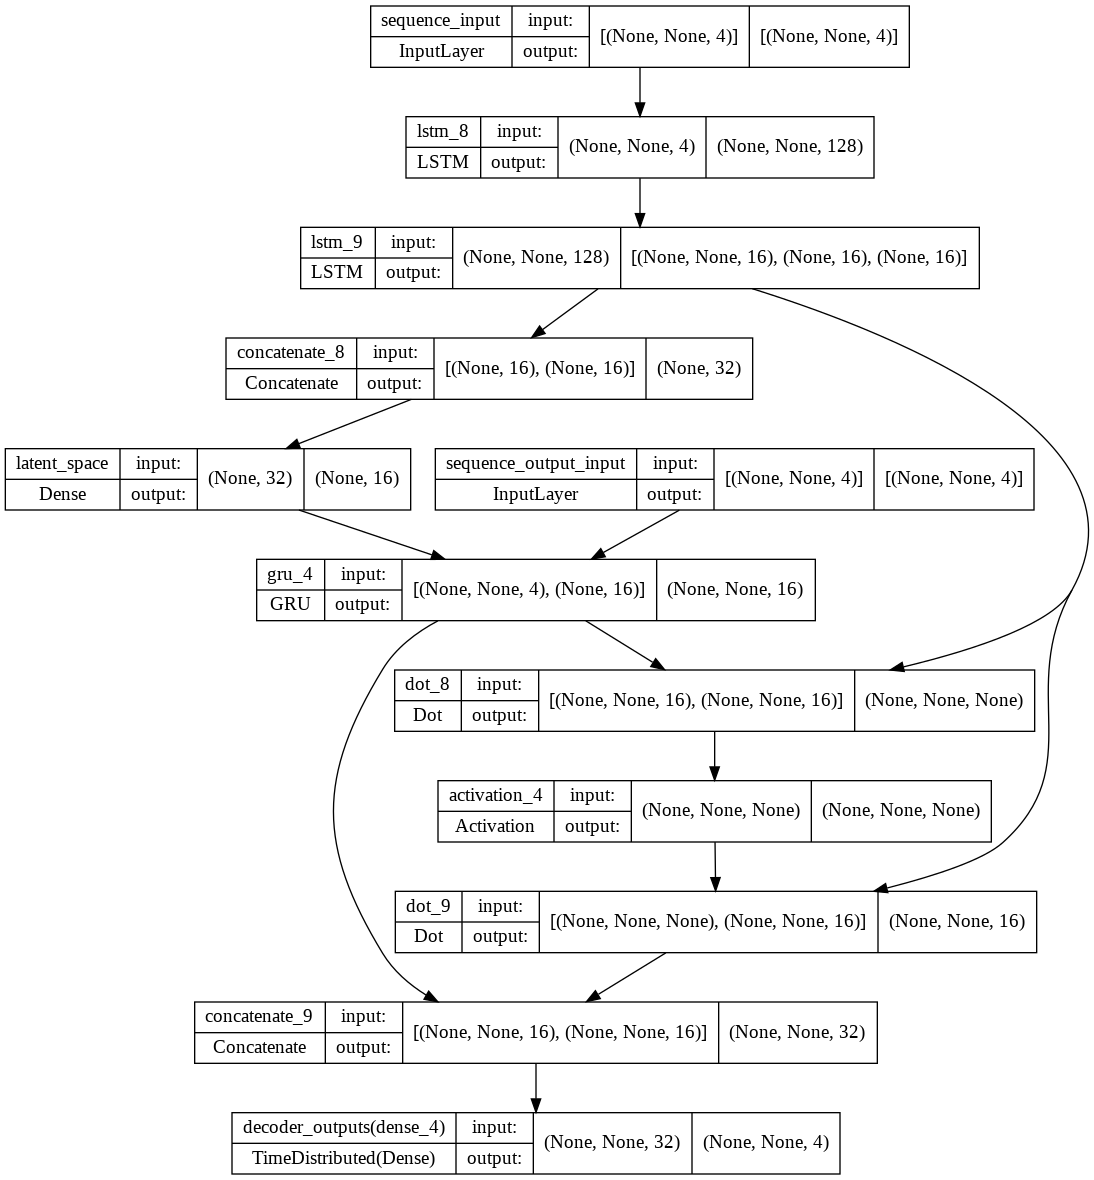

In [ ]:
average_loss = np.average(training_history.history['loss'])
print("Average test loss: ", round(average_loss , 4))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
encoder = Model(model.input, model.get_layer("latent_space").output)
predictions = encoder.predict(inputs, batch_size = batch_size,verbose=1)

9/9 [==============================] - 11s 1s/step


In [ ]:
opt_cluster_numbers = 3
n_components = 2

# encoder-decoder LSTM features
sc = StandardScaler()
standard_predictions = sc.fit_transform(predictions)
pca = PCA(n_components=n_components)
X_predictions = pca.fit_transform(standard_predictions)

# Dynamic time warping features
distance_matrix = np.load(dataset_path + '/distance_matrix3.npy')

sc = StandardScaler()
standard_distance_matrix = sc.fit_transform(distance_matrix)
pca = PCA(n_components=n_components)
X_distance_matrix = pca.fit_transform(standard_distance_matrix/5)

# Customer demographic features
sc = StandardScaler()
standard_static = sc.fit_transform(static_input_array)
pca = PCA(n_components=n_components)
X_standard_static = pca.fit_transform(standard_static)

F = np.multiply(X_predictions, X_distance_matrix)
final_feature_set = np.concatenate((X_standard_static,F), axis=1)
# def random_mix(X, Y):
#     choice = np.random.randint(2, size = X.size).reshape(X.shape).astype(bool)
#     return np.where(choice, X, Y)

# F = random_mix(X_predictions, X_standard_static)
# B = random_mix(F, X_distance_matrix)

# final_feature_set = np.add(X_distance_matrix,X_standard_static, X_predictions)
# final_feature_set = np.multiply(F, static_input_array)

sc = StandardScaler()
standard_hybrid = sc.fit_transform(final_feature_set)
pca = PCA(n_components=n_components)
X_hybrid = pca.fit_transform(standard_hybrid)

In [ ]:
opt_cluster_numbers = 4
def get_scatter(X,name):
  kmeans = KMeans(n_clusters = opt_cluster_numbers, **kmeans_kwargs)
  kmeans.fit(X)
  labels = kmeans.labels_
  unique, counts = np.unique(labels, return_counts=True)
  cluster_count = dict(zip(unique, counts))

  silhouette = round(silhouette_score(X, labels),3)
  davies_bouldin = round(davies_bouldin_score(X, labels),3)
  # distance_matrices = pairwise_distances(X)
  # dunk = dunn(labels, distance_matrices)
  
  print(name)
  # print(cluster_count)
  # print("Silhouette: ", silhouette , " The best value is 1 and the worst value is -1.")
  # print("Davies–Bouldin index: ", davies_bouldin, " lower values indicating better clustering.")
  # print("Dunn index: ", round(dunk, 6))
  print(silhouette ,"&",davies_bouldin)

  scatter =  go.Scatter(x=X[:, 0], y=X[:, 1],mode='markers',
        marker=dict(
            color=labels,
            line_width=1
        ))

  return scatter

In [ ]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=("Encoder-Decoder LSTM", "Dynamic Time Warping","RFM Score","Hybrid Approach"),
                    vertical_spacing=0.02)

fig.add_trace(get_scatter(X_predictions,"X_predictions"),row=1, col=1)

fig.add_trace(get_scatter(X_distance_matrix,"X_distance_matrix"),row=2, col=1)

fig.add_trace(get_scatter(X_rfm,"X_rfm"),row=3, col=1)

fig.add_trace(get_scatter(X_hybrid,"X_hybrid"),row=4, col=1)

fig.update_layout(height=800, width=1000, title_text="Czech Beka bank customer clustering")
fig.show()


X_predictions
0.716 & 0.598
X_distance_matrix
0.567 & 0.562
X_rfm
0.437 & 0.745
X_hybrid
0.893 & 0.471
